# Import libraries

In [31]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
from scipy.fft import fft, fftfreq
from scipy.signal import butter, filtfilt

# Load Data 

In [2]:
eda_df = pd.read_csv('./src/notebooks/data/wesad_eda_empatica.csv', sep=';')
eda_comps = pd.read_csv('./src/notebooks/data/eda_comps.csv', sep=';')
bvp_df = pd.read_csv('./src/notebooks/data/wesad_bvp_empatica.csv', sep=';')
acc_df = pd.read_csv('./src/notebooks/data/wesad_acc_empatica.csv', sep=';')
temp_df = pd.read_csv('./src/notebooks/data/wesad_temp_empatica.csv', sep=';')
resp_df = pd.read_csv('./src/notebooks/data/wesad_resp_empatica.csv', sep=';')
emg_df = pd.read_csv('./src/notebooks/data/wesad_emg_empatica.csv', sep=';')
ecg_df = pd.read_csv('./src/notebooks/data/wesad_ecg_empatica.csv', sep=';')
label_df = pd.read_csv('./src/notebooks/data/wesad_label_empatica.csv', sep=';')

In [518]:
acc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2779776 entries, 0 to 2779775
Data columns (total 4 columns):
 #   Column   Dtype  
---  ------   -----  
 0   subject  object 
 1   x_axis   float64
 2   y_axis   float64
 3   z_axis   float64
dtypes: float64(3), object(1)
memory usage: 84.8+ MB


In [3]:
# Process EDA components separately 
eda_phasic_df = eda_comps[['subject', 'phasic']]
eda_tonic_df = eda_comps[['subject', 'tonic']]
eda_smna_df = eda_comps[['subject', 'smna']]

# Compute the ACC magnitude as descirbed in the paper
acc_df['magnitude'] = np.sqrt(acc_df['x_axis']**2 + acc_df['y_axis']**2 + acc_df['z_axis']**2)


<Axes: >

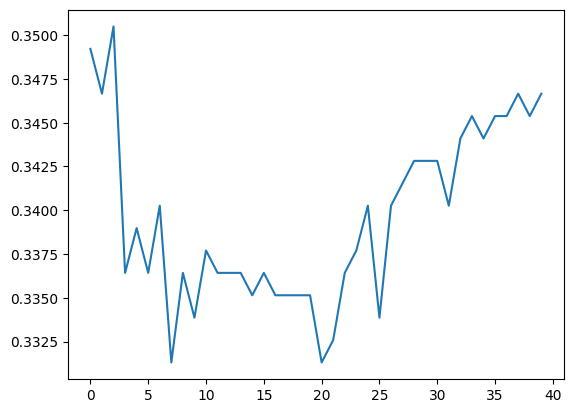

In [36]:
eda_df.EDA[0:4 * 10].plot()

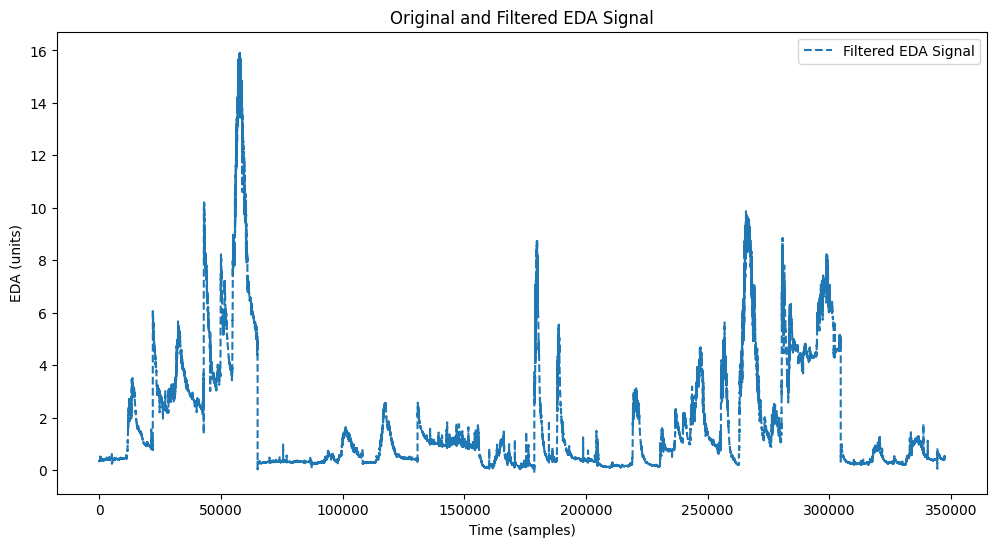

In [41]:
def butter_lowpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

eda_signal = eda_df['EDA'].values
fs = 4.0  # Sampling frequency of the EDA signal (4 Hz)
cutoff = 1.0  # Desired cutoff frequency of the filter (1 Hz)
filtered_eda = lowpass_filter(eda_signal, cutoff, fs, order=5)
plt.figure(figsize=(12, 6))
plt.plot(filtered_eda, label='Filtered EDA Signal', linestyle='--')
plt.xlabel('Time (samples)')
plt.ylabel('EDA (units)')
plt.legend()
plt.title('Original and Filtered EDA Signal')
plt.show()


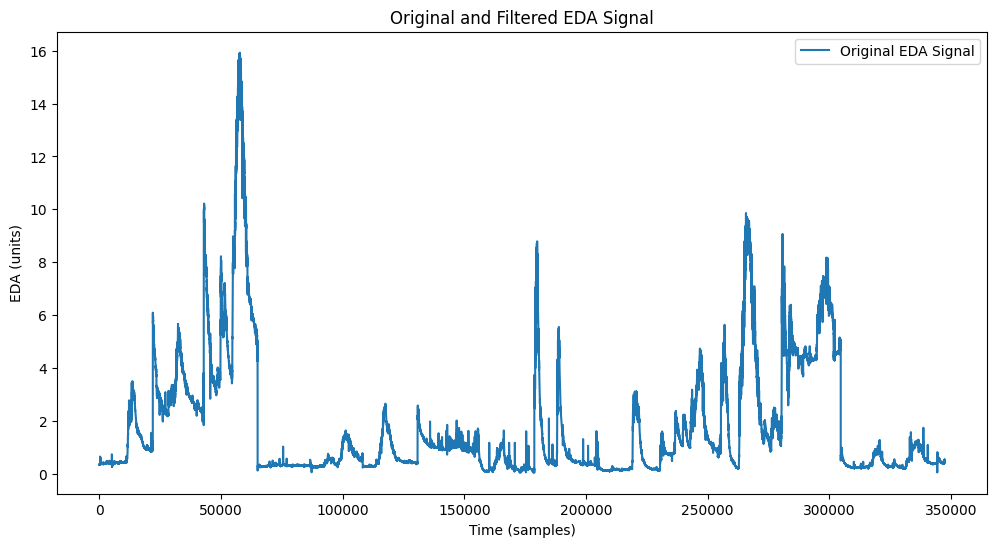

In [40]:
plt.figure(figsize=(12, 6))
plt.plot(eda_df.EDA, label='Original EDA Signal')
plt.xlabel('Time (samples)')
plt.ylabel('EDA (units)')
plt.legend()
plt.title('Original and Filtered EDA Signal')
plt.show()


In [44]:
eda_df['filtered_eda'] = filtered_eda
eda_df

,subject,EDA,filtered_eda
0,S10,0.349215,0.349214
1,S10,0.346656,0.349563
2,S10,0.350494,0.345871
3,S10,0.336423,0.340205
4,S10,0.338981,0.337380
...,...,...,...
347467,S9,0.499144,0.497703
347468,S9,0.494028,0.496014
347469,S9,0.496586,0.496242
347470,S9,0.497865,0.496959


# Feature extraction

In [4]:

def non_overlapping_rolling_stats(data, window_size, signal_name, sampling_rate):
    
    peak_freq_signals = ['EMG', 'BVP']
    slope_signals = ["TEMP"]
    
    mean_vals = []
    std_vals = []
    min_vals = []
    max_vals = []
    peak_freqs = []
    slopes = []
    
    for start in range(0, len(data), window_size):
        window_data = data[start:start + window_size]
        if len(window_data) == window_size:
            mean_vals.append(np.round(window_data.mean(), 2))
            std_vals.append(np.round(window_data.std(ddof=0), 2))
            min_vals.append(np.round(window_data.min(), 2))
            max_vals.append(np.round(window_data.max(), 2))
            
            if signal_name in peak_freq_signals : 
                # FFT to calculate peak frequency
                yf = fft(window_data.values)
                xf = fftfreq(window_size, 1 / sampling_rate)
                peak_freq = xf[np.argmax(np.abs(yf))]
                peak_freqs.append(peak_freq)
                
            if signal_name in slope_signals : 
                x = np.arange(window_size)
                y = window_data
                p = np.polyfit(x, y, 1)
                slopes.append(p[0])
    
    if signal_name in peak_freq_signals : 
        result = pd.DataFrame({
        f'{signal_name}mean': mean_vals,
        f'{signal_name}std': std_vals,
        f'{signal_name}min': min_vals,
        f'{signal_name}max': max_vals, 
        f'{signal_name}peak_freq': peak_freqs
        })
    elif signal_name in slope_signals : 
        result = pd.DataFrame({
        f'{signal_name}mean': mean_vals,
        f'{signal_name}std': std_vals,
        f'{signal_name}min': min_vals,
        f'{signal_name}max': max_vals, 
        f'{signal_name}slope': slopes
        })
    else : 
        result = pd.DataFrame({
        f'{signal_name}mean': mean_vals,
        f'{signal_name}std': std_vals,
        f'{signal_name}min': min_vals,
        f'{signal_name}max': max_vals
    })
    return result

Mean slope = 0.009000


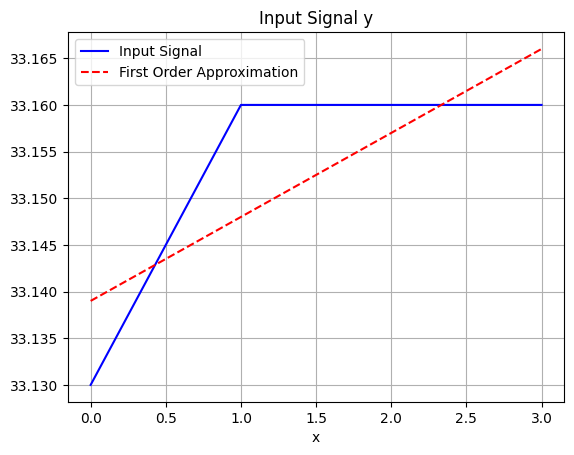

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Generate input signal
window_data = temp_df[0 : 4]
x = np.arange(4)
y = window_data['TEMP']
# y = (-0.002 * x + 3) + np.abs(np.sin(2 * np.pi * 0.002 * x)) + 0.2 * np.sin(2 * np.pi * 0.01 * x)

# Plot input signal
plt.figure()
plt.plot(x, y, '-b')
plt.grid(True)
plt.xlabel('x')
plt.title('Input Signal y')
plt.hold = True

# First order approximation
p = np.polyfit(x, y, 1)
polyValues = p[0] * x + p[1]
plt.plot(x, polyValues, '--r')
plt.legend(['Input Signal', 'First Order Approximation'])

# Display the slope
print(f'Mean slope = {p[0]:.6f}')

# Show the plot
plt.show()


In [6]:
def feature_extraction(data, window_size, signal_name, sampling_rate) : 
    subjects_lst = data.subject.unique() 

    temp_subject_lst = []
    temp_feats_lst = []
    for subject in subjects_lst : 
        subject_data = data[data['subject'] == subject][signal_name] 
        features = non_overlapping_rolling_stats(data=subject_data, window_size=window_size, signal_name=signal_name, sampling_rate=sampling_rate)
        temp_feats_lst.append(features)
        for _ in range(0, int(features.shape[0])) : 
            temp_subject_lst.append(subject)


    features = pd.DataFrame()
    for feat_df in temp_feats_lst : 
        features = pd.concat([features, feat_df], axis=0)



    features = features.reset_index()
    features = pd.concat([features, pd.DataFrame(temp_subject_lst)], axis=1)
    features = features.rename(columns={
        0 : 'subject'
    })
    
    print(f'{signal_name} feature extraction : feature set shape : {features.shape}')
    
    return features


In [7]:
import pandas as pd
import numpy as np
from scipy.stats import mode

window_size = 4

def non_overlapping_rolling_labels(data, window_size):
    mode_vals = []
    
    for start in range(0, len(data), window_size):
        window_data = data[start:start + window_size]
        if len(window_data) == window_size:
            mode_vals.append(mode(window_data).mode)  
    
    result = pd.DataFrame({
        'label': mode_vals
    })
    return result

In [46]:
window_size = 4
sampling_rate = 4
eda_features = feature_extraction(eda_df, window_size=window_size, signal_name=eda_df.columns[2], sampling_rate=sampling_rate)
eda_phasic_features = feature_extraction(eda_phasic_df, window_size=window_size, signal_name=eda_phasic_df.columns[1], sampling_rate=sampling_rate)
eda_tonic_features = feature_extraction(eda_tonic_df, window_size=window_size, signal_name=eda_tonic_df.columns[1], sampling_rate=sampling_rate)
eda_smna_features = feature_extraction(eda_smna_df, window_size=window_size, signal_name=eda_smna_df.columns[1], sampling_rate=sampling_rate)
temp_features = feature_extraction(temp_df, window_size=window_size, signal_name=temp_df.columns[1], sampling_rate=sampling_rate)
window_size = 32
x_acc_features = feature_extraction(acc_df, window_size=window_size, signal_name='x_axis',sampling_rate=sampling_rate)
y_acc_features = feature_extraction(acc_df, window_size=window_size, signal_name='y_axis', sampling_rate=sampling_rate)
z_acc_features = feature_extraction(acc_df, window_size=window_size, signal_name='z_axis', sampling_rate=sampling_rate)
magnitude_acc_features = feature_extraction(acc_df, window_size=window_size, signal_name='magnitude', sampling_rate=sampling_rate)

window_size = 64
sampling_rate = 4
bvp_features = feature_extraction(bvp_df, window_size=window_size, signal_name=bvp_df.columns[1], sampling_rate=sampling_rate)

window_size = 700 
sampling_rate = 4
resp_features = feature_extraction(resp_df, window_size=window_size, signal_name=resp_df.columns[1], sampling_rate=sampling_rate)
ecg_features = feature_extraction(ecg_df, window_size=window_size, signal_name=ecg_df.columns[1], sampling_rate=sampling_rate)
emg_features = feature_extraction(emg_df, window_size=window_size, signal_name=emg_df.columns[1], sampling_rate=sampling_rate)


filtered_eda feature extraction : feature set shape : (86868, 6)
phasic feature extraction : feature set shape : (86868, 6)
tonic feature extraction : feature set shape : (86868, 6)
smna feature extraction : feature set shape : (86868, 6)
TEMP feature extraction : feature set shape : (86868, 7)
x_axis feature extraction : feature set shape : (86868, 6)
y_axis feature extraction : feature set shape : (86868, 6)
z_axis feature extraction : feature set shape : (86868, 6)
magnitude feature extraction : feature set shape : (86868, 6)
BVP feature extraction : feature set shape : (86868, 7)
RESP feature extraction : feature set shape : (86868, 6)
ECG feature extraction : feature set shape : (86868, 6)
EMG feature extraction : feature set shape : (86868, 7)


In [16]:
np.round(eda_df['EDA'][0 : 4].mean(), 2) 

0.35

In [12]:
eda_features

,index,EDAmean,EDAstd,EDAmin,EDAmax,subject
0,0,0.35,0.01,0.34,0.35,S10
1,1,0.34,0.00,0.33,0.34,S10
2,2,0.34,0.00,0.33,0.34,S10
3,3,0.34,0.00,0.34,0.34,S10
4,4,0.34,0.00,0.34,0.34,S10
...,...,...,...,...,...,...
86863,5218,0.50,0.00,0.49,0.50,S9
86864,5219,0.49,0.01,0.49,0.50,S9
86865,5220,0.50,0.00,0.50,0.50,S9
86866,5221,0.50,0.00,0.50,0.50,S9


In [47]:
window_size = 700 
labels = non_overlapping_rolling_labels(label_df['label'], window_size=window_size)

In [48]:
# chech that the feature extraction is done correctly. 
# All features dataframes should have the same shape

print(f'----------------------------------------------')
print(f'labels shape : {labels.shape}')
print(f'eda_features shape : {eda_features.shape}')
print(f'temp_features shape : {temp_features.shape}')
print(f'x_acc_features shape : {x_acc_features.shape}')
print(f'y_acc_features shape : {y_acc_features.shape}')
print(f'z_acc_features shape : {z_acc_features.shape}')
print(f'resp_features shape : {resp_features.shape}')
print(f'emg_features shape : {emg_features.shape}')
print(f'ecg_features shape : {ecg_features.shape}')
print(f'labels shape : {labels.shape}')
print(f'----------------------------------------------')

----------------------------------------------
labels shape : (86868, 1)
eda_features shape : (86868, 6)
temp_features shape : (86868, 7)
x_acc_features shape : (86868, 6)
y_acc_features shape : (86868, 6)
z_acc_features shape : (86868, 6)
resp_features shape : (86868, 6)
emg_features shape : (86868, 7)
ecg_features shape : (86868, 6)
labels shape : (86868, 1)
----------------------------------------------


In [127]:
print(f"eda_df[eda_df['subject'] == 'S10'][0 : 4]['EDA'].values mean : {np.round(np.mean(eda_df[eda_df['subject'] == 'S10'][0 : 4]['EDA'].values), 2)}")
print(f"eda_df[eda_df['subject'] == 'S10'][0 : 4]['EDA'].values mean : {np.round(np.mean(eda_df[eda_df['subject'] == 'S10'][4 : 8]['EDA'].values), 2)}")
print(f"eda_df[eda_df['subject'] == 'S10'][0 : 4]['EDA'].values mean : {np.round(np.mean(eda_df[eda_df['subject'] == 'S10'][8 : 12]['EDA'].values), 2)}")

eda_df[eda_df['subject'] == 'S10'][0 : 4]['EDA'].values mean : 0.35
eda_df[eda_df['subject'] == 'S10'][0 : 4]['EDA'].values mean : 0.34
eda_df[eda_df['subject'] == 'S10'][0 : 4]['EDA'].values mean : 0.34


In [126]:
print(f"eda_features[eda_features['subject'] == 'S10']['EDAmean'].iloc[0] : {eda_features[eda_features['subject'] == 'S10']['EDAmean'].iloc[0]}")
print(f"eda_features[eda_features['subject'] == 'S10']['EDAmean'].iloc[0] : {eda_features[eda_features['subject'] == 'S10']['EDAmean'].iloc[1]}")
print(f"eda_features[eda_features['subject'] == 'S10']['EDAmean'].iloc[0] : {eda_features[eda_features['subject'] == 'S10']['EDAmean'].iloc[2]}")

eda_features[eda_features['subject'] == 'S10']['EDAmean'].iloc[0] : 0.35
eda_features[eda_features['subject'] == 'S10']['EDAmean'].iloc[0] : 0.34
eda_features[eda_features['subject'] == 'S10']['EDAmean'].iloc[0] : 0.34


# Data Transformation 

In [49]:
feature_set = pd.DataFrame()
feature_set = pd.concat([feature_set, eda_features, temp_features, 
                         x_acc_features, y_acc_features, z_acc_features, 
                         bvp_features, 
                        #  resp_features, emg_features, 
                        #  ecg_features, 
                         eda_phasic_features, 
                         eda_tonic_features, eda_smna_features, 
                         labels], 
                        axis=1) 

feature_set

,index,filtered_edamean,filtered_edastd,filtered_edamin,filtered_edamax,subject,index,TEMPmean,TEMPstd,TEMPmin,...,tonicmin,tonicmax,subject,index,smnamean,smnastd,smnamin,smnamax,subject,label
0,0,0.35,0.0,0.34,0.35,S10,0,33.15,0.01,33.13,...,0.34,0.34,S10,0,0.00,0.00,0.0,0.00,S10,0
1,1,0.34,0.0,0.34,0.34,S10,1,33.15,0.00,33.15,...,0.34,0.34,S10,1,0.00,0.00,0.0,0.00,S10,0
2,2,0.34,0.0,0.33,0.34,S10,2,33.16,0.00,33.15,...,0.34,0.34,S10,2,0.00,0.00,0.0,0.00,S10,0
3,3,0.34,0.0,0.34,0.34,S10,3,33.15,0.00,33.15,...,0.34,0.34,S10,3,0.00,0.00,0.0,0.00,S10,0
4,4,0.34,0.0,0.33,0.34,S10,4,33.16,0.00,33.15,...,0.34,0.34,S10,4,0.00,0.00,0.0,0.00,S10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86863,5218,0.50,0.0,0.49,0.50,S9,5218,31.95,0.00,31.95,...,0.49,0.49,S9,5218,0.00,0.00,0.0,0.00,S9,0
86864,5219,0.50,0.0,0.49,0.50,S9,5219,31.94,0.01,31.93,...,0.49,0.49,S9,5219,0.01,0.02,0.0,0.04,S9,0
86865,5220,0.50,0.0,0.50,0.50,S9,5220,31.94,0.01,31.93,...,0.49,0.49,S9,5220,0.00,0.00,0.0,0.00,S9,0
86866,5221,0.50,0.0,0.50,0.50,S9,5221,31.96,0.01,31.95,...,0.49,0.50,S9,5221,0.00,0.00,0.0,0.00,S9,0


In [50]:
# Remove label and subject columns to perform data transformations

feature_set_ = feature_set.drop(labels=['index'], axis=1)
feature_set_ = feature_set_.T.drop_duplicates().T # Remove duplicate subject columns
feature_set_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86868 entries, 0 to 86867
Data columns (total 40 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   filtered_edamean  86868 non-null  object
 1   filtered_edastd   86868 non-null  object
 2   filtered_edamin   86868 non-null  object
 3   filtered_edamax   86868 non-null  object
 4   subject           86868 non-null  object
 5   TEMPmean          86868 non-null  object
 6   TEMPstd           86868 non-null  object
 7   TEMPmin           86868 non-null  object
 8   TEMPmax           86868 non-null  object
 9   TEMPslope         86868 non-null  object
 10  x_axismean        86868 non-null  object
 11  x_axisstd         86868 non-null  object
 12  x_axismin         86868 non-null  object
 13  x_axismax         86868 non-null  object
 14  y_axismean        86868 non-null  object
 15  y_axisstd         86868 non-null  object
 16  y_axismin         86868 non-null  object
 17  y_axismax   

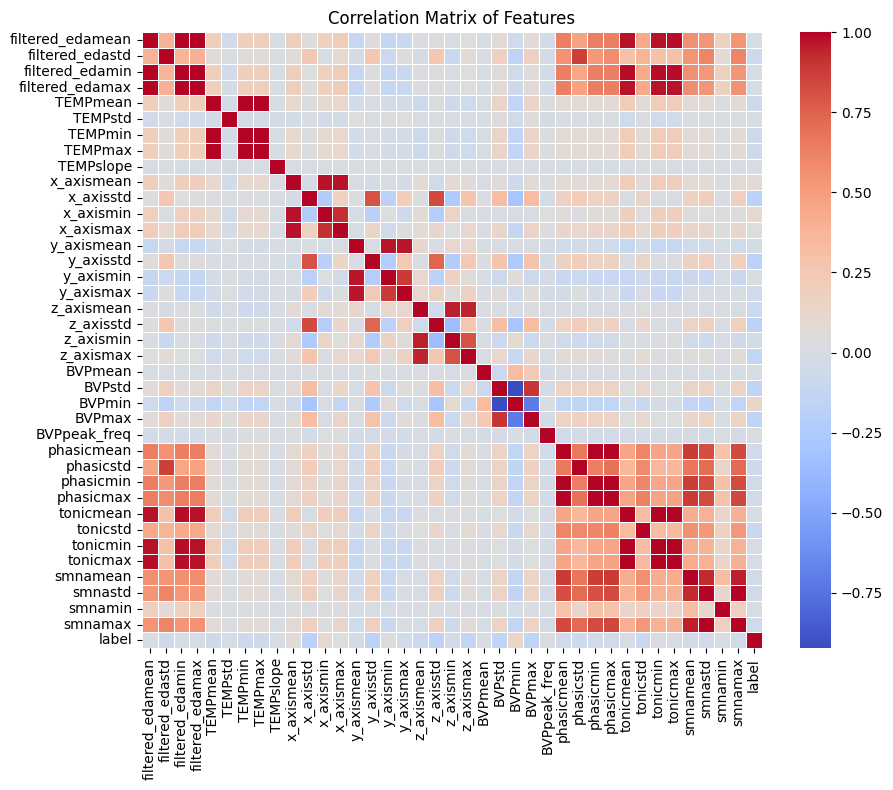

In [51]:
correlation_matrix = feature_set_.drop(labels=['subject'], axis=1).corr()  # Exclude the last two columns 'subject' and 'label'

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Features')
plt.show()

In [52]:
# Remove subjects and labels columns 
labels_col = feature_set_.label 
feature_set_.drop(labels=['label'], axis=1, inplace=True)

subjects_col = feature_set_.subject      
feature_set_.drop(labels=['subject'], axis=1, inplace=True)

feature_set_.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86868 entries, 0 to 86867
Data columns (total 38 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   filtered_edamean  86868 non-null  object
 1   filtered_edastd   86868 non-null  object
 2   filtered_edamin   86868 non-null  object
 3   filtered_edamax   86868 non-null  object
 4   TEMPmean          86868 non-null  object
 5   TEMPstd           86868 non-null  object
 6   TEMPmin           86868 non-null  object
 7   TEMPmax           86868 non-null  object
 8   TEMPslope         86868 non-null  object
 9   x_axismean        86868 non-null  object
 10  x_axisstd         86868 non-null  object
 11  x_axismin         86868 non-null  object
 12  x_axismax         86868 non-null  object
 13  y_axismean        86868 non-null  object
 14  y_axisstd         86868 non-null  object
 15  y_axismin         86868 non-null  object
 16  y_axismax         86868 non-null  object
 17  z_axismean  

In [53]:
# Convert columns datatype to int 

feature_set_ = feature_set_.astype('float')
feature_set_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86868 entries, 0 to 86867
Data columns (total 38 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   filtered_edamean  86868 non-null  float64
 1   filtered_edastd   86868 non-null  float64
 2   filtered_edamin   86868 non-null  float64
 3   filtered_edamax   86868 non-null  float64
 4   TEMPmean          86868 non-null  float64
 5   TEMPstd           86868 non-null  float64
 6   TEMPmin           86868 non-null  float64
 7   TEMPmax           86868 non-null  float64
 8   TEMPslope         86868 non-null  float64
 9   x_axismean        86868 non-null  float64
 10  x_axisstd         86868 non-null  float64
 11  x_axismin         86868 non-null  float64
 12  x_axismax         86868 non-null  float64
 13  y_axismean        86868 non-null  float64
 14  y_axisstd         86868 non-null  float64
 15  y_axismin         86868 non-null  float64
 16  y_axismax         86868 non-null  float6

In [54]:
feature_set_.shape

(86868, 38)

In [55]:
# Data transformations : Quantile Transformer and Standard Scalar

from sklearn.preprocessing import QuantileTransformer, StandardScaler
from sklearn.decomposition import PCA

pca = PCA(n_components=20, svd_solver='full')
pca_df = pca.fit_transform(feature_set_)
pca_df = pd.DataFrame(pca_df, columns=[f'PC{i}' for i in range(1, 21)])

transformer = QuantileTransformer(n_quantiles=int(86868 / 2), subsample=int(86868 / 2))
transformed_data = transformer.fit_transform(pca_df)
transformed_data = pd.DataFrame(transformed_data)
transformed_data.columns = pca_df.columns

scaled_data = transformed_data
scaled_data.columns = transformed_data.columns

scaler = StandardScaler()
scaled_data = scaler.fit_transform(pca_df)
scaled_data = pd.DataFrame(scaled_data)
scaled_data.columns = pca_df.columns


array([[<Axes: title={'center': 'PC1'}>, <Axes: title={'center': 'PC2'}>,
        <Axes: title={'center': 'PC3'}>, <Axes: title={'center': 'PC4'}>],
       [<Axes: title={'center': 'PC5'}>, <Axes: title={'center': 'PC6'}>,
        <Axes: title={'center': 'PC7'}>, <Axes: title={'center': 'PC8'}>],
       [<Axes: title={'center': 'PC9'}>,
        <Axes: title={'center': 'PC10'}>,
        <Axes: title={'center': 'PC11'}>,
        <Axes: title={'center': 'PC12'}>],
       [<Axes: title={'center': 'PC13'}>,
        <Axes: title={'center': 'PC14'}>,
        <Axes: title={'center': 'PC15'}>,
        <Axes: title={'center': 'PC16'}>],
       [<Axes: title={'center': 'PC17'}>,
        <Axes: title={'center': 'PC18'}>,
        <Axes: title={'center': 'PC19'}>,
        <Axes: title={'center': 'PC20'}>]], dtype=object)

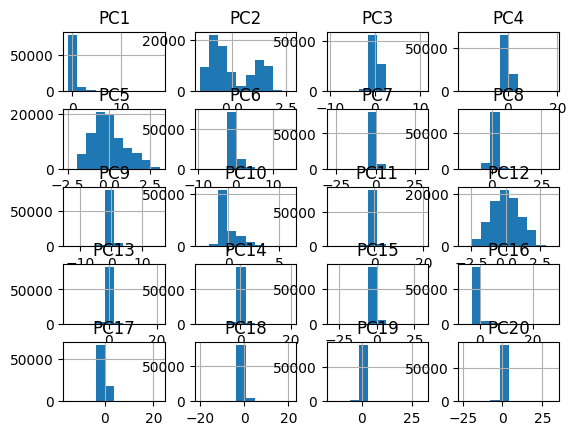

In [56]:
scaled_data.hist()

In [57]:
# Put the subject and label column to the scaled data frame 
# to train the model using leave-one-subject-out cross validation

scaled_data['subject'] = subjects_col
scaled_data['label'] = labels_col

if scaled_data.label.dtype.name == "object" : 
    scaled_data.label = scaled_data.label.astype('int')

scaled_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86868 entries, 0 to 86867
Data columns (total 22 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   PC1      86868 non-null  float64
 1   PC2      86868 non-null  float64
 2   PC3      86868 non-null  float64
 3   PC4      86868 non-null  float64
 4   PC5      86868 non-null  float64
 5   PC6      86868 non-null  float64
 6   PC7      86868 non-null  float64
 7   PC8      86868 non-null  float64
 8   PC9      86868 non-null  float64
 9   PC10     86868 non-null  float64
 10  PC11     86868 non-null  float64
 11  PC12     86868 non-null  float64
 12  PC13     86868 non-null  float64
 13  PC14     86868 non-null  float64
 14  PC15     86868 non-null  float64
 15  PC16     86868 non-null  float64
 16  PC17     86868 non-null  float64
 17  PC18     86868 non-null  float64
 18  PC19     86868 non-null  float64
 19  PC20     86868 non-null  float64
 20  subject  86868 non-null  object 
 21  label    868

In [58]:
# Remove data points that does not belong to classes : [0, 1, 2] 
# Other data points have no interesting labels for out classification task
# for more details check weasd_readme.pdf 

# scaled_data_ is a scaled_data version used in training and testing.
scaled_data_ = scaled_data[(scaled_data['label'] == 0) | (scaled_data['label'] == 1) | (scaled_data['label'] == 2)]

In [59]:
# Calculate how many data points are lost 

print(f'- We have lost {scaled_data.shape[0] - scaled_data_.shape[0]} datasets')
print(f'- We have lost {((scaled_data.shape[0] - scaled_data_.shape[0]) / scaled_data.shape[0]) * 100} % of data')

- We have lost 19784 datasets
- We have lost 22.774784730856013 % of data


# Train the model 

## SVM 

<Axes: >

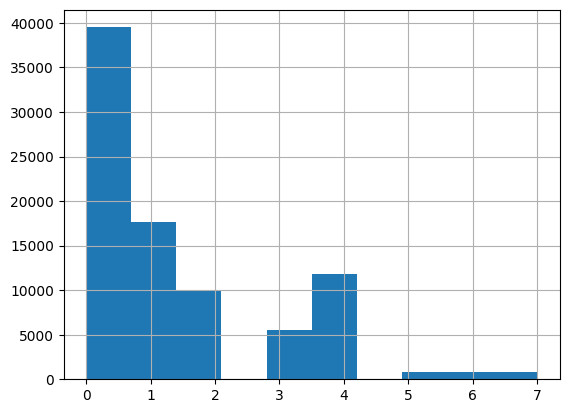

In [37]:
# Visualize the label distribution before filtering unwanted labels


scaled_data.label.hist()

<Axes: >

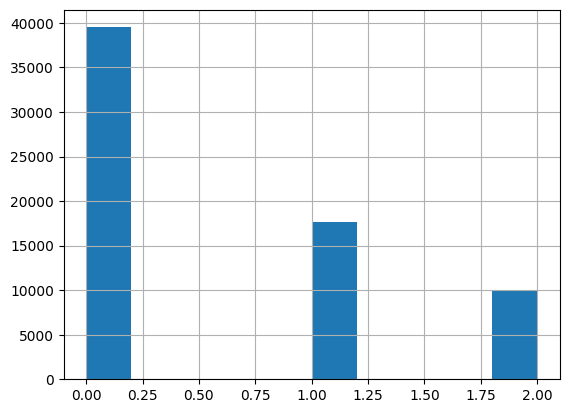

In [38]:
# Visualize the label distribution after filtering unwanted labels

scaled_data_.label.hist() 

In [60]:
# Due the label filtering, we need to update our list of subjects

subjects_col_ = scaled_data_.subject 
subjects_col_.shape

(67084,)

In [343]:
# For testing purposes. Remove a random subject from the scaled_data_ 

# test_subject = scaled_data_[scaled_data_['subject'] == 'S10']
# scaled_data_ = scaled_data_[~(scaled_data_['subject'] == 'S10')]

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,subject,label
0,0.850905,0.010953,1.485921,0.954256,-1.724485,1.721283,1.260471,1.488602,1.570395,1.747028,...,1.711061,1.715939,1.704014,-1.748491,1.629252,-1.678784,-1.710384,1.482899,S10,0
1,1.504100,0.123268,-1.315866,-1.456362,-1.502268,-1.668124,1.501417,-0.570427,1.399391,1.531317,...,1.128621,-1.330852,1.282167,-1.146979,-0.799377,-1.382263,0.769823,-0.204628,S10,0
2,-1.335808,0.011262,-0.346334,-1.432025,-1.543960,0.456899,-0.631399,-0.490387,1.476707,-0.664492,...,-1.140308,-0.739578,0.814226,0.566655,0.770143,0.460596,1.183944,-0.199314,S10,0
3,-1.325492,0.003511,-0.905263,-1.427346,-1.488602,0.369478,0.313307,-0.495154,1.294799,1.496017,...,-0.735655,0.378920,0.620521,-1.334862,1.262317,-1.168453,0.424387,-0.197657,S10,0
4,-1.067765,-0.001646,-1.213587,-1.418504,-1.485982,0.062257,1.110760,-0.869834,1.360275,0.843495,...,-1.277626,0.776229,0.694036,-0.522796,-0.637507,0.413079,0.070373,-0.195399,S10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5491,0.217727,-0.116028,-0.948538,-1.382785,-1.630045,-0.228845,1.457332,-0.452878,1.194914,1.301463,...,1.366175,0.089888,0.866493,-0.481075,0.477264,-0.502926,0.954047,0.039551,S10,0
5492,-1.138227,-0.129577,-0.854168,-1.376643,-1.578985,0.250920,1.363265,0.221628,0.873668,1.094050,...,0.730151,1.033438,0.809716,-1.299795,0.111757,0.403779,0.188676,-1.644992,S10,0
5493,-1.144816,-0.186125,-0.993265,-1.369465,-1.692848,1.068951,1.194234,-0.926134,-1.313338,1.287287,...,1.577984,-0.897864,0.453767,-1.508124,1.485773,1.175619,0.320106,0.081827,S10,0
5494,0.327109,0.267318,1.346266,0.923357,-1.736982,1.721283,1.422833,1.478716,-1.703705,1.749362,...,1.714504,1.715484,1.706148,-1.740940,1.676132,-1.729292,-1.709000,0.383171,S10,0


In [61]:
from sklearn.svm import SVC
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

# model = SVC(kernel='rbf', C=10, gamma=0.001)
svm_model = SVC(kernel='rbf')
# model = SVC(kernel='rbf',  class_weight='balanced')

logo = LeaveOneGroupOut()

groups = scaled_data_.subject
X = scaled_data_.drop(columns=['label', 'subject'])
y = scaled_data_.label 

svm_confusion_matrices = []
accuracies = []
f1_scores = []
subjects_ids = [] 

counter = 1

print(f"- len subjects_id : {len(subjects_col_)}")
print(f"- len subjects_id : {subjects_col_.shape}")
print(f"- len X : {len(X)}")
print(f"- len y : {len(y)}")

debug_counter = 0
debug_x_train_lst = []
debug_x_test_lst = []

print(f"- Start the training process")
for fold_idx, (train_index, test_index) in enumerate(logo.split(X, y, groups=groups), start=1):
    
    train_subjects = np.unique(groups.iloc[train_index])
    test_subjects = np.unique(groups.iloc[test_index])
    
    print(f"Fold {fold_idx}:")
    print(f"Subjects in training set: {train_subjects}")
    print(f"Subjects in testing set: {test_subjects}")
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # if debug_counter < 2 : 
    #     debug_x_train_lst.append(X_train)
    #     debug_x_test_lst.append(X_train)
    # else : 
    #     break 
    
    debug_counter += 1 
    
    svm_model.fit(X_train, y_train)
    y_pred = svm_model.predict(X_test)
    
    print(f'y_pred: {y_pred}')
    print(f'y_true: {y_test.values}')
    
    if np.array_equal(y_pred, y_test.values) : 
        print(f'y_pred and y_test are equal')
    else : 
        print(f'y_pred and y_test have different values')
        

    cm = confusion_matrix(y_test, y_pred)
    svm_confusion_matrices.append(cm)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    f1 = f1_score(y_test, y_pred, average="weighted")
    f1_scores.append(f1)
    
    print(f"{fold_idx}- Accuracy: {accuracy}")
    print(f"{fold_idx}- f1-score: {f1}")
 

# Summary of results
accuracies = np.array(accuracies)
f1_scores = np.array(f1_scores)
print(f"The avg accuracy: {accuracies.mean()}")
print(f"The avg f1_scores: {f1_scores.mean()}")
print(f"The std accuracy: {accuracies.std()}")
print(f"The min accuracy: {accuracies.min()}")
print(f"The max accuracy: {accuracies.max()}")

- len subjects_id : 67084
- len subjects_id : (67084,)
- len X : 67084
- len y : 67084
- Start the training process
Fold 1:
Subjects in training set: ['S11' 'S13' 'S14' 'S15' 'S16' 'S17' 'S2' 'S3' 'S4' 'S5' 'S6' 'S7' 'S8'
 'S9']
Subjects in testing set: ['S10']
y_pred: [0 0 1 ... 0 0 0]
y_true: [0 0 0 ... 0 0 0]
y_pred and y_test have different values
1- Accuracy: 0.704191616766467
1- f1-score: 0.6927192975790997
Fold 2:
Subjects in training set: ['S10' 'S13' 'S14' 'S15' 'S16' 'S17' 'S2' 'S3' 'S4' 'S5' 'S6' 'S7' 'S8'
 'S9']
Subjects in testing set: ['S11']
y_pred: [0 1 0 ... 0 0 0]
y_true: [0 0 0 ... 0 0 0]
y_pred and y_test have different values
2- Accuracy: 0.6606323304436512
2- f1-score: 0.6561227795859832
Fold 3:
Subjects in training set: ['S10' 'S11' 'S14' 'S15' 'S16' 'S17' 'S2' 'S3' 'S4' 'S5' 'S6' 'S7' 'S8'
 'S9']
Subjects in testing set: ['S13']
y_pred: [0 0 0 ... 0 0 0]
y_true: [0 0 0 ... 0 0 0]
y_pred and y_test have different values
3- Accuracy: 0.5107235446617959
3- f1-score

In [350]:
pred = svm_model.predict(test_subject.drop(columns=['subject', 'label']))
acc = accuracy_score(y_true=test_subject.label, y_pred=pred)
acc

0.9990419161676647

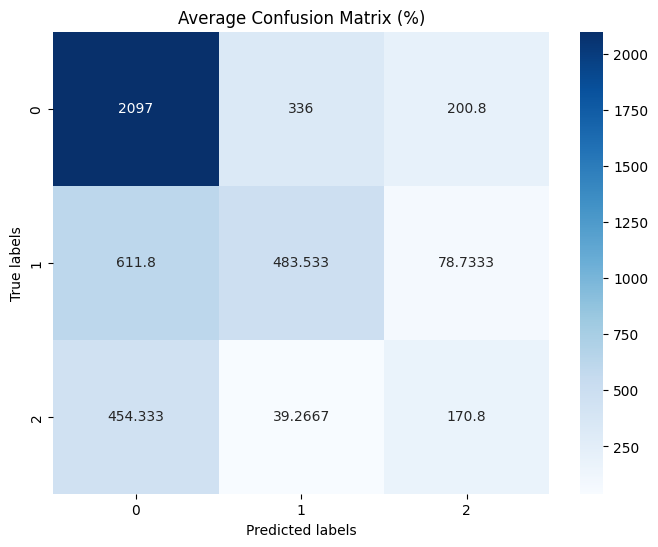

In [30]:
def compute_average_confusion_matrix(confusion_matrices):
    # Filter out matrices with different shapes
    base_shape = confusion_matrices[0].shape
    filtered_matrices = [cm for cm in confusion_matrices if cm.shape == base_shape]

    # Sum all matrices
    sum_matrix = np.sum(filtered_matrices, axis=0)
    
    # Compute the average
    avg_matrix = sum_matrix / len(filtered_matrices)
    
    return avg_matrix

def convert_to_percentage(matrix):
    percentage_matrix = matrix * 100
    return percentage_matrix

# Compute the average confusion matrix
average_confusion_matrix = compute_average_confusion_matrix(svm_confusion_matrices)
# average_confusion_matrix = convert_to_percentage(average_confusion_matrix)
# print("Average Confusion Matrix:\n", average_confusion_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(average_confusion_matrix, annot=True, cmap='Blues', fmt='g', cbar = True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Average Confusion Matrix (%)')
plt.show()

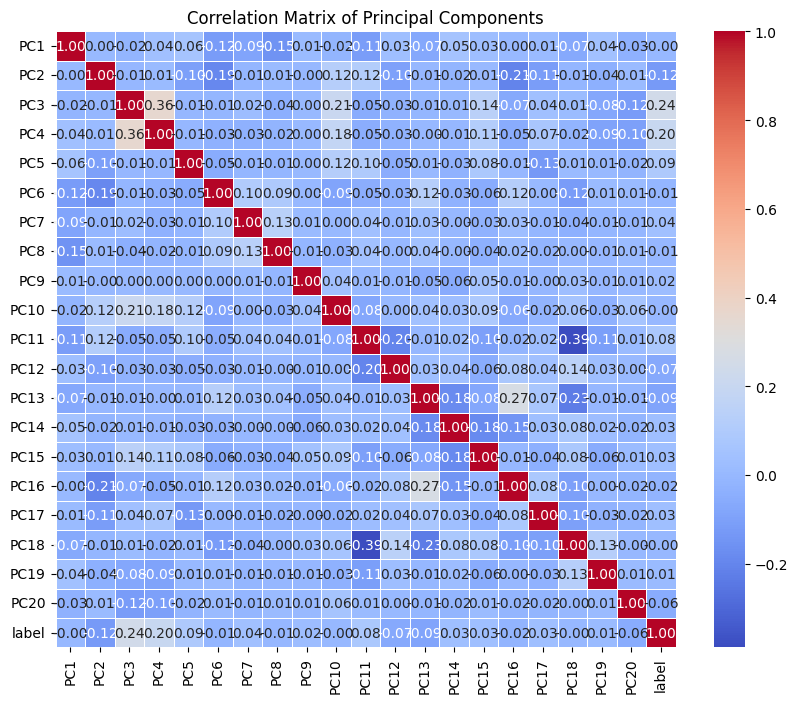

In [515]:


# Assuming 'scaled_data_' is your DataFrame
# Calculate the correlation matrix
correlation_matrix = scaled_data_.drop(labels=['subject'], axis=1).corr()  # Exclude the last two columns 'subject' and 'label'

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Principal Components')
plt.show()


## Decision tree 

In [63]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

# Assuming you have the scaled_data_ DataFrame with 'label' and 'subject' columns
# scaled_data_ = pd.read_csv('path_to_your_scaled_data.csv')  # Uncomment if loading from a CSV

# Set up the data
groups = scaled_data_['subject']
X = scaled_data_.drop(columns=['label', 'subject'])
y = scaled_data_['label']

# Initialize the models
dt_model = DecisionTreeClassifier(criterion='entropy', min_samples_split=10, max_depth=4)
rf_model = RandomForestClassifier(criterion='entropy', min_samples_split=10, max_depth=9, n_estimators=100)

# Leave-One-Group-Out Cross-Validation
logo = LeaveOneGroupOut()

def evaluate_model(model, X, y, groups):
    confusion_matrices = []
    accuracies = []
    f1_scores = []
    
    for fold_idx, (train_index, test_index) in enumerate(logo.split(X, y, groups=groups), start=1):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        cm = confusion_matrix(y_test, y_pred)
        confusion_matrices.append(cm)
        accuracies.append(accuracy_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred, average='weighted'))
    
    accuracies = np.array(accuracies)
    f1_scores = np.array(f1_scores)
    
    return {
        'confusion_matrices': confusion_matrices,
        'accuracies': accuracies,
        'f1_scores': f1_scores,
        'avg_accuracy': accuracies.mean(),
        'avg_f1_score': f1_scores.mean(),
        'std_accuracy': accuracies.std(),
        'min_accuracy': accuracies.min(),
        'max_accuracy': accuracies.max()
    }

# Evaluate Decision Tree model
dt_results = evaluate_model(dt_model, X, y, groups)
print(f"Decision Tree - Average Accuracy: {dt_results['avg_accuracy']}")
print(f"Decision Tree - Average F1 Score: {dt_results['avg_f1_score']}")

# # Evaluate Random Forest model
rf_results = evaluate_model(rf_model, X, y, groups)
print(f"Random Forest - Average Accuracy: {rf_results['avg_accuracy']}")
print(f"Random Forest - Average F1 Score: {rf_results['avg_f1_score']}")

# Output Summary of Results
def print_summary(results, model_name):
    print(f"{model_name} - Summary of Results")
    print(f"Average Accuracy: {results['avg_accuracy']}")
    print(f"Average F1 Score: {results['avg_f1_score']}")
    print(f"Standard Deviation of Accuracy: {results['std_accuracy']}")
    print(f"Minimum Accuracy: {results['min_accuracy']}")
    print(f"Maximum Accuracy: {results['max_accuracy']}")
    print()

print_summary(dt_results, "Decision Tree")
print_summary(rf_results, "Random Forest")


Decision Tree - Average Accuracy: 0.5918418513258304
Decision Tree - Average F1 Score: 0.5339189950738782


# Troubleshoot the model 

## Issue 1

In [354]:
# Check data distribution for each subject

feature_set_['subject'] = subjects_col_ 
feature_set_

,EDAmean,EDAstd,EDAmin,EDAmax,TEMPmean,TEMPstd,TEMPmin,TEMPmax,x_axismean,x_axisstd,...,y_axismax,z_axismean,z_axisstd,z_axismin,z_axismax,BVPmean,BVPstd,BVPmin,BVPmax,subject
0,0.345697,0.006385,0.336423,0.350494,33.1525,0.015,33.13,33.16,48.87500,28.943493,...,45.0,22.78125,39.594505,-69.0,127.0,10.416406,15.138922,-17.98,38.01,S10
1,0.336743,0.003960,0.331306,0.340260,33.1525,0.005,33.15,33.16,57.37500,0.793116,...,24.0,16.15625,0.627816,15.0,18.0,-13.630313,92.557997,-164.37,152.00,S10
2,0.336103,0.001609,0.333865,0.337702,33.1575,0.005,33.15,33.16,57.37500,0.975506,...,22.0,16.62500,0.491869,16.0,17.0,5.570469,8.185182,-12.79,15.60,S10
3,0.336103,0.000640,0.335144,0.336423,33.1525,0.005,33.15,33.16,56.68750,0.470929,...,23.0,17.06250,0.353553,16.0,18.0,1.118594,8.277259,-15.11,13.50,S10
4,0.335144,0.000000,0.335144,0.335144,33.1575,0.005,33.15,33.16,56.56250,0.564401,...,23.0,17.28125,0.456803,17.0,18.0,-3.273438,9.947549,-22.48,13.75,S10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82435,0.956198,0.002185,0.953320,0.958437,30.8450,0.010,30.83,30.85,54.18750,0.859013,...,21.0,25.96875,0.782237,25.0,28.0,-5.757500,16.846475,-30.19,28.02,S9
82436,0.953640,0.001225,0.952041,0.954600,30.8500,0.000,30.85,30.85,54.03125,0.474129,...,20.0,25.90625,0.465547,25.0,27.0,-3.387500,10.023474,-17.62,15.02,S9
82437,0.952681,0.001279,0.952041,0.954600,30.8350,0.010,30.83,30.85,54.46875,0.671271,...,20.0,26.03125,1.331610,25.0,31.0,-2.771562,8.663791,-19.43,13.17,S9
82438,0.946285,0.003977,0.941808,0.950762,30.8450,0.010,30.83,30.85,56.03125,24.008714,...,46.0,15.93750,49.723064,-96.0,127.0,3.741250,8.362186,-11.02,20.92,S9


<Axes: >

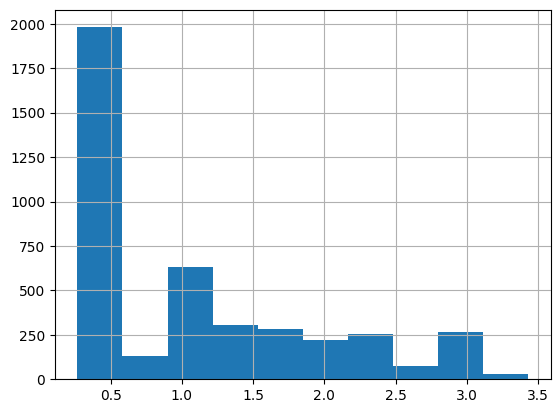

In [358]:
feature_set_[feature_set_['subject'] == 'S10']['EDAmin'].hist()

<Axes: >

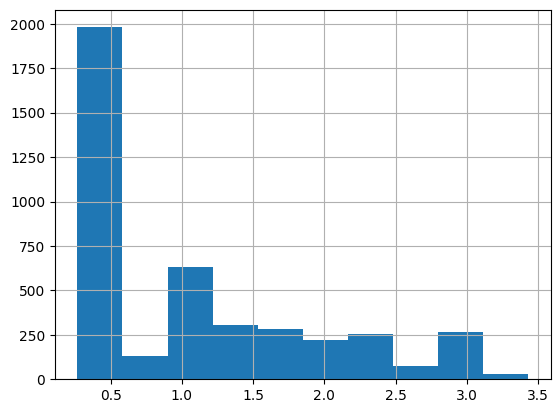

In [359]:
feature_set_[feature_set_['subject'] == 'S11']['EDAmin'].hist()

Two subjects have the same data distribution. We checked the actual values and we found that they have the same signal values, which due to potential issues in data collection process or in feature extraction process. 

In [375]:
eda_df[eda_df['subject'] == 'S10']['EDA']

0        0.349215
1        0.346656
2        0.350494
3        0.336423
4        0.338981
           ...   
21979    0.941808
21980    0.940529
21981    0.931574
21982    0.932854
21983    0.932854
Name: EDA, Length: 21984, dtype: float64

In [376]:
feature_set_[feature_set_['subject'] == 'S10']['EDAmin']

0       0.336423
1       0.331306
2       0.333865
3       0.335144
4       0.335144
          ...   
5491    0.953320
5492    0.952041
5493    0.952041
5494    0.941808
5495    0.931574
Name: EDAmin, Length: 4175, dtype: float64